# Oops... Nothing Here..  So, you are on your own this time.

In [1]:

import sys
print(sys.version)

3.5.2 |Continuum Analytics, Inc.| (default, Jul  5 2016, 11:41:13) [MSC v.1900 64 bit (AMD64)]


In [2]:
#Plot
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

#Data Packages
import math
import pandas
import numpy as np

#Progress bar
from tqdm import tqdm

#Counter
from collections import Counter

#Operation
import operator

#Natural Language Processing Packages
import re
import nltk

## Download Resources
nltk.download("vader_lexicon")
nltk.download("stopwords")
nltk.download("averaged_perceptron_tagger")
nltk.download("wordnet")

from nltk.sentiment import SentimentAnalyzer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.sentiment.util import *
from nltk import tokenize
from nltk.corpus import stopwords
from nltk.tag import PerceptronTagger
from nltk.data import find

## Machine Learning
import sklearn
import sklearn.metrics as metrics

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\sextonem\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\sextonem\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\sextonem\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\sextonem\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [3]:
#try to get data..........AGH
hotelDf = pandas.read_csv('reviews4.csv')
hotelDf.columns=['idNum','filePath','hotelName','reviewColumn','ratingScore','groundTruth']

In [4]:
hotelDf.head()

,idNum,filePath,hotelName,reviewColumn,ratingScore,groundTruth
0,531560410,data4\ca\154913\10259142\535933244.html,Element Calgary Airport,I really enjoyed my stay here. The room had a ...,5,positive
1,535933244,data4\ca\154913\10259142\537074672.html,Element Calgary Airport,We stayed one night in this new hotel and it's...,5,positive
2,537074672,data4\ca\154913\10259142\538137131.html,Element Calgary Airport,Stayed at this hotel for business trip purpose...,5,positive
3,538137131,data4\ca\154913\10259142\540014523.html,Element Calgary Airport,Very clean. Modern and bright. GREAT mattress ...,4,positive
4,504192408,data4\ca\154913\10276193\504653214.html,Hilton Garden Inn Calgary Downtown,My partner and I and another couple stayed in ...,4,positive


In [5]:
# Use vader to evaluated sentiment of reviews
def evalSentences(sentences, to_df=False, columns=[]):
    #Instantiate an instance to access SentimentIntensityAnalyzer class
    sid = SentimentIntensityAnalyzer()
    pdlist = []
    if to_df:
        for sentence in tqdm(sentences):
            ss = sid.polarity_scores(sentence) #vader
            pdlist.append([sentence]+[ss['compound']])
        reviewDf = pandas.DataFrame(pdlist)
        reviewDf.columns = columns
        return reviewDf
    
    else:
        for sentence in tqdm(sentences):
            print(sentence)
            ss = sid.polarity_scores(sentence)
            for k in sorted(ss):
                print('{0}: {1}, '.format(k, ss[k]), end='')
            print()

In [6]:
reviews = hotelDf['reviewColumn'].astype(str)

In [7]:
reviewDf = evalSentences(reviews, to_df=True, columns=['reviewCol','vader'])

100%|█████████████████████████████████████████████████████████████████████████████| 3611/3611 [00:08<00:00, 410.25it/s]


In [8]:
reviewDf.head()

,reviewCol,vader
0,I really enjoyed my stay here. The room had a ...,0.9701
1,We stayed one night in this new hotel and it's...,0.9939
2,Stayed at this hotel for business trip purpose...,0.9530
3,Very clean. Modern and bright. GREAT mattress ...,0.9090
4,My partner and I and another couple stayed in ...,0.8108


In [9]:
#mututal info: log(p(x,y)/p(x)p(y)) -- point wise mutual info
#tokenizes all words in review and creates encoder (there not there)  basically
#have there not there, have pos or neg, can then get mutual info 
# Note: You may want to use an NLTK tokenizer instead of a regular expression in the following
def dataFrameTransformation(hotelDf, reviewDf):
    reviewSens = reviewDf['reviewCol'].values
    
    stop = set(stopwords.words('english'))

    # Top-k frequent terms
    counter = Counter()
    for review in reviewSens:
            counter.update([word.lower() 
                            for word 
                            in re.findall(r'\w+', review) 
                            if word.lower() not in stop and len(word) > 2])
    topk = counter.most_common(500)        
    
    #Find out if a particular review has the word from topk list
    freqReview = []
    for i in range(len(reviews)):
        tempCounter = Counter([word.lower() for word in re.findall(r'\w+',reviews[i])])
        topkinReview = [1 if tempCounter[word] > 0 else 0 for (word,wordCount) in topk]
        freqReview.append(topkinReview)
        
        
    #Prepare freqReviewDf
    freqReviewDf = pandas.DataFrame(freqReview)
    dfName = []
    for c in topk:
        dfName.append(c[0])
    freqReviewDf.columns = dfName
    finalreviewDf = reviewDf.join(freqReviewDf)
    finaldf = hotelDf[['hotelName','ratingScore','groundTruth']].join(finalreviewDf)
    return topk, finaldf

In [10]:
topk, finaldf = dataFrameTransformation(hotelDf, reviewDf)

In [11]:
itemAnalysisDf = finaldf[['reviewCol','groundTruth','vader']]

In [12]:
hotelNames = finaldf['hotelName'].unique()

# Question 1

In [13]:
def getHotelRank(df, measure, ascend):
    #Rank the hotel by ground truth rating score
    hotelRating = []
    for hotel in hotelNames:
        itemDf = df.loc[df['hotelName']==hotel]
        hotelRating.append([hotel,itemDf[measure].mean()])
    hotelRatingDfGt = pandas.DataFrame(hotelRating)
    hotelRatingDfGt.columns=['hotelName','avg_' +measure]
    hotelRatingDfGt = hotelRatingDfGt.sort_values('avg_'+measure,ascending=ascend)
    return hotelRatingDfGt

In [14]:
hotelRatingDfGtBEST = getHotelRank(finaldf, measure= 'ratingScore', ascend=0)

In [15]:
hotelRatingDfGtBEST.head()

,hotelName,avg_ratingScore
63,Hotel Elan,4.909091
43,Calgary Marriott Downtown Hotel,4.763636
0,Element Calgary Airport,4.750000
58,Residence Inn by Marriott Calgary Airport,4.710526
9,Hotel Le Germain Calgary,4.655963


In [16]:
hotelRatingDfVdBEST = getHotelRank(finaldf, measure='vader', ascend=0)

In [17]:
hotelRatingDfVdBEST.head()

,hotelName,avg_vader
28,Sheraton Cavalier Hotel,0.962738
0,Element Calgary Airport,0.956500
58,Residence Inn by Marriott Calgary Airport,0.942253
57,Wingate by Wyndham Calgary South,0.939400
19,Hotel Blackfoot,0.926823


In [18]:
hotelRatingDfGtWorst = getHotelRank(finaldf, measure= 'ratingScore', ascend=1)

In [19]:
hotelRatingDfGtWorst.head()

,hotelName,avg_ratingScore
45,Ramada Limited Calgary Northwest,1.541667
51,Travelodge Hotel Calgary Macleod Trail,1.612903
50,Travelodge Hotel Calgary International Airport...,2.109091
46,Super 8 Village Calgary AB,2.416667
24,Canadas Best Value Inn Chinook Station,2.484848


In [20]:
hotelRatingDfVdWorst = getHotelRank(finaldf, measure='vader', ascend=1)

In [21]:
hotelRatingDfVdWorst.head()

,hotelName,avg_vader
51,Travelodge Hotel Calgary Macleod Trail,-0.154829
45,Ramada Limited Calgary Northwest,-0.127279
21,Coast Plaza Hotel & Conference Centre,0.114663
46,Super 8 Village Calgary AB,0.133275
50,Travelodge Hotel Calgary International Airport...,0.141569


1B) In both cases, the average vader ratings produce a different top/bottom 5, with some overlapping.  for best there is only one hotel that appears with both methods and with worst there are three hotels in common (diff order though).  This is interesting, and could show that what star rating people give is not necessarily reflective of their text answer- or, avg vader just didn't do a great job at predicting the ranking vs the avg star ranking.

# Question 2

In [22]:
def getTopK(df, k, label_value, label_column='groundTruth', operation=operator.eq, value_column='reviewCol'):
    stop = set(stopwords.words('english'))
    #Add possible Stop Words for Hotel Reviews
    stop.add('hotel')
    stop.add('room')
    stop.add('rooms')
    stop.add('stay')
    stop.add('staff')
    counter = Counter()
    for review in df.loc[operation(df[label_column],label_value)][value_column]:
            counter.update([word.lower() 
                            for word 
                            in re.findall(r'\w+', review) 
                            if word.lower() not in stop and len(word) > 2])
    topk = counter.most_common(k)
    return topk

In [23]:
topkGroundPos = getTopK(df=itemAnalysisDf, k=50, label_value='positive')

In [24]:
topkGroundPos

[('great', 1698),
 ('good', 1315),
 ('calgary', 1295),
 ('clean', 1153),
 ('breakfast', 1104),
 ('nice', 1082),
 ('would', 966),
 ('stayed', 883),
 ('friendly', 854),
 ('service', 853),
 ('comfortable', 827),
 ('well', 819),
 ('one', 784),
 ('location', 713),
 ('airport', 641),
 ('pool', 611),
 ('night', 605),
 ('helpful', 587),
 ('downtown', 553),
 ('restaurant', 548),
 ('also', 536),
 ('bed', 533),
 ('desk', 512),
 ('area', 512),
 ('front', 510),
 ('time', 505),
 ('excellent', 495),
 ('really', 493),
 ('free', 483),
 ('food', 480),
 ('close', 462),
 ('parking', 450),
 ('get', 417),
 ('place', 415),
 ('beds', 410),
 ('like', 390),
 ('check', 386),
 ('bathroom', 381),
 ('could', 372),
 ('modern', 365),
 ('recommend', 359),
 ('business', 357),
 ('restaurants', 356),
 ('large', 347),
 ('best', 340),
 ('definitely', 336),
 ('hot', 334),
 ('back', 330),
 ('two', 323),
 ('quiet', 320)]

In [25]:
topkGroundNeg = getTopK(df=itemAnalysisDf, k=50, label_value='negative')

In [26]:
topkGroundNeg

[('would', 454),
 ('one', 365),
 ('night', 350),
 ('good', 327),
 ('desk', 303),
 ('stayed', 289),
 ('breakfast', 284),
 ('front', 271),
 ('get', 269),
 ('clean', 267),
 ('bed', 251),
 ('like', 234),
 ('calgary', 225),
 ('could', 218),
 ('even', 216),
 ('time', 209),
 ('nice', 208),
 ('place', 195),
 ('service', 193),
 ('location', 175),
 ('back', 173),
 ('well', 172),
 ('great', 171),
 ('pool', 169),
 ('next', 167),
 ('bathroom', 165),
 ('also', 165),
 ('check', 164),
 ('got', 163),
 ('floor', 162),
 ('day', 158),
 ('told', 158),
 ('door', 145),
 ('booked', 143),
 ('free', 143),
 ('never', 141),
 ('first', 140),
 ('really', 140),
 ('parking', 136),
 ('area', 135),
 ('small', 134),
 ('price', 133),
 ('two', 133),
 ('morning', 131),
 ('airport', 129),
 ('hot', 128),
 ('friendly', 127),
 ('said', 127),
 ('went', 125),
 ('food', 121)]

2A) there is a lot of overlap, which is interesting.  I think it speaks to the power of using phrases because for example bed appears in both, but depending on the descriptor it could actually be 'comfortable bed' or 'dirty bed' which would be a lot more insightful.  Calgary appears in both lists which is locale specific.  The positive list did contain more affirming words like good, great, excellent etc, but the neg contains a lot of these words too like good, great, friendly.

In [27]:
tagger = PerceptronTagger()

In [28]:
# Part of Speech Tagging
# Google: https://en.wikipedia.org/wiki/Part-of-speech_tagging
pos_tag = tagger.tag
#taggedToks = pos_tag(re.findall(r'\w+', text))

In [29]:
# This grammar is described in the paper by S. N. Kim,
# T. Baldwin, and M.-Y. Kan.
# Evaluating n-gram based evaluation metrics for automatic
# keyphrase extraction.
# Technical report, University of Melbourne, Melbourne 2010.
#regex for nlp chunker, will cut out key words for you 
grammar = r"""
    NBAR:
        {<NN.*|JJ>*<NN.*>}  # Nouns and Adjectives, terminated with Nouns
        
    NP:
        {<NBAR>}
        {<NBAR><IN><NBAR>}  # Above, connected with in/of/etc...
"""

In [30]:
# Create phrase tree
chunker = nltk.RegexpParser(grammar)
#tree= chunker.parse(taggedToks)

In [31]:
# Noun Phrase Extraction Support Functions
from nltk.corpus import stopwords
stopwrds = stopwords.words('english')
lemmatizer = nltk.WordNetLemmatizer()
stemmer = nltk.stem.porter.PorterStemmer()

# generator, generate leaves one by one
def leaves(tree):
    """Finds NP (nounphrase) leaf nodes of a chunk tree."""
    for subtree in tree.subtrees(filter = lambda t: t.label()=='NP' or t.label()=='JJ' or t.label()=='RB'):
        yield subtree.leaves()

# stemming, lematizing, lower case... 
def normalise(word):
    """Normalises words to lowercase and stems and lemmatizes it."""
    word = word.lower()
    word = stemmer.stem(word)
    word = lemmatizer.lemmatize(word)
    return word

# stop-words and length control
def acceptable_word(word):
    """Checks conditions for acceptable word: length, stopword."""
    accepted = bool(2 <= len(word) <= 40
        and word.lower() not in stopwrds)
    return accepted

# generator, create item once a time
def get_terms(tree):
    for leaf in leaves(tree):
        term = [normalise(w) for w,t in leaf if acceptable_word(w) ]
        # Phrase only
        if len(term)>1:
            yield term

In [32]:
# Flatten phrase lists to get tokens for analysis
def flatten(npTokenList):
    finalList =[]
    for phrase in npTokenList:
        token = ''
        for word in phrase:
            token += word + ' '
        finalList.append(token.rstrip())
    return finalList

In [33]:
# Revise the previous dataframe transform function...
def newDataFrameTransformation(hotelDf, reviewDF, k=500):
    reviews = reviewDF['reviewCol'].values
    
    # Top-k frequent terms
    counter = Counter()
    for review in reviews:
            counter.update(flatten([word
                            for word 
                            in get_terms(chunker.parse(pos_tag(re.findall(r'\w+', review)))) 
                            ]))
    topk = counter.most_common(k)        
    
    #Find out if a particular review has the word from topk list
    freqReview = []
    for i in range(len(reviews)):
        tempCounter = Counter(flatten([word 
                                       for word 
                                       in get_terms(chunker.parse(pos_tag(re.findall(r'\w+',reviews[i]))))]))
        topkinReview = [1 if tempCounter[word] > 0 else 0 for (word,wordCount) in topk]
        freqReview.append(topkinReview)
        
        
    #Prepare freqReviewDf
    freqReviewDf = pandas.DataFrame(freqReview)
    dfName = []
    for c in topk:
        dfName.append(c[0])
    freqReviewDf.columns = dfName
    finalreviewDf = reviewDF.join(freqReviewDf)
    finaldf = hotelDf[['hotelName','ratingScore','groundTruth']].join(finalreviewDf)
    return topk, finaldf

In [34]:
topk_phrase, finaldf_phrase = newDataFrameTransformation(hotelDf, reviewDf)

In [74]:
def getTopKPhrase( df, label_value ,label_column='groundTruth', operation=operator.eq, value_column='reviewCol'):
    counter = Counter()
    #for word in topk:
    for review in df.loc[operation(df[label_column],label_value)][value_column]:
            counter.update(flatten([word
                            for word 
                            in get_terms(chunker.parse(pos_tag(re.findall(r'\w+', review)))) 
                            ]))
    topk = counter.most_common(50)                  
    return topk
                                         
                                           

In [75]:
topkGroundPos_phrase = getTopKPhrase( df=finaldf_phrase, label_value='positive')

In [76]:
topkGroundPos_phrase

[('front desk', 171),
 ('hot tub', 103),
 ('front desk staff', 95),
 ('downtown calgari', 87),
 ('hotel art', 81),
 ('calgari tower', 63),
 ('great locat', 59),
 ('comfort bed', 57),
 ('great place', 51),
 ('breakfast buffet', 51),
 ('room servic', 47),
 ('great hotel', 47),
 ('hotel staff', 46),
 ('friendli staff', 45),
 ('hotel room', 45),
 ('next time', 43),
 ('pool area', 43),
 ('free breakfast', 42),
 ('good valu', 40),
 ('good locat', 39),
 ('continent breakfast', 39),
 ('great stay', 35),
 ('night stay', 34),
 ('le germain', 33),
 ('calgari airport', 33),
 ('next morn', 33),
 ('first time', 33),
 ('nice touch', 32),
 ('busi trip', 31),
 ('calgari stamped', 30),
 ('nice hotel', 29),
 ('easi access', 28),
 ('water slide', 28),
 ('busi travel', 28),
 ('next day', 26),
 ('bedroom suit', 26),
 ('complimentari breakfast', 26),
 ('hotel restaur', 25),
 ('good hotel', 25),
 ('minut walk', 25),
 ('clean room', 25),
 ('great servic', 24),
 ('shuttl servic', 24),
 ('great view', 24),
 ('go

In [77]:
topkGroundNeg_phrase = getTopKPhrase( df=finaldf_phrase, label_value='negative')

In [78]:
topkGroundNeg_phrase

[('front desk', 117),
 ('hot tub', 42),
 ('front desk staff', 32),
 ('next day', 31),
 ('credit card', 28),
 ('next morn', 28),
 ('hotel room', 24),
 ('continent breakfast', 20),
 ('hot water', 18),
 ('differ room', 18),
 ('park lot', 17),
 ('non smoke room', 17),
 ('night stay', 14),
 ('room servic', 14),
 ('air condition', 14),
 ('sever time', 13),
 ('free breakfast', 12),
 ('clean room', 12),
 ('star hotel', 12),
 ('great locat', 12),
 ('first night', 12),
 ('first time', 11),
 ('desk clerk', 11),
 ('comfort inn', 11),
 ('phone call', 10),
 ('second floor', 10),
 ('hotel staff', 10),
 ('downtown calgari', 10),
 ('long time', 10),
 ('new room', 10),
 ('good locat', 10),
 ('smoke room', 10),
 ('custom servic', 10),
 ('last night', 9),
 ('hampton inn', 9),
 ('room rate', 9),
 ('coffe maker', 9),
 ('second night', 9),
 ('holiday inn', 9),
 ('second time', 9),
 ('next time', 8),
 ('queen bed', 8),
 ('sofa bed', 8),
 ('stamped week', 8),
 ('air condit', 8),
 ('airport hotel', 8),
 ('first

2B) still quite a bit of overlap, but overall the phrases are more descriptive and make sense.  The positive superlatives are gone from the neg results as well for the most part

# Question 3

In [219]:
# get Top K mutual information terms from the dataframe
def getMI(topk, df, label_column='groundTruth'):
    miScore = []
    for word in topk:
        miScore.append([word[0]]+[metrics.mutual_info_score(df[label_column], df[word[0]])])
    miScoredf = pandas.DataFrame(miScore).sort_values(1,ascending=0)
    miScoredf.columns = ['Word','MI Score']
    return miScoredf

In [220]:
#run the preprocesser topk with number of unique words, so find number of unique words, janky but dint care sorry
miScoredf = getMI(topk, finaldf)

In [221]:
miScoredf.head(50)

,Word,MI Score
298,dirty,0.029381
4,great,0.028314
125,told,0.020002
2,staff,0.014692
42,excellent,0.013663
18,comfortable,0.012570
134,said,0.012539
145,old,0.011669
117,amazing,0.010499
29,helpful,0.010450


3A) there isnt anything locale specific in these ones.  most mutual info terms are dirty and great- both quite polarizing and probably quite frequent.

In [222]:
finaldf_phrase.head()

,hotelName,ratingScore,groundTruth,reviewCol,vader,front desk,hot tub,front desk staff,downtown calgari,hotel art,...,hotel would stay,au clair market,valu would,friend wed,mani restaur great experi overal classi,queen bed cost,valu add,courtyard side,hotel buffet,clean conveni locat excel servic
0,Element Calgary Airport,5,positive,I really enjoyed my stay here. The room had a ...,0.9701,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Element Calgary Airport,5,positive,We stayed one night in this new hotel and it's...,0.9939,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Element Calgary Airport,5,positive,Stayed at this hotel for business trip purpose...,0.9530,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Element Calgary Airport,4,positive,Very clean. Modern and bright. GREAT mattress ...,0.9090,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Hilton Garden Inn Calgary Downtown,4,positive,My partner and I and another couple stayed in ...,0.8108,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0


In [223]:
miScoredNP = getMI(topk_phrase, finaldf_phrase)

In [224]:
miScoredNP.head(50)

,Word,MI Score
106,non smoke room,0.006478
31,credit card,0.005328
0,front desk,0.004030
22,great hotel,0.003486
81,differ room,0.003338
4,hotel art,0.003067
13,next day,0.002891
198,smoke room,0.002809
7,calgari tower,0.002439
165,desk clerk,0.002338


3B) these paint a picture of horror: blood stain, black mold, bed bug-  these all sound like they would relate to VERY strong reactions, so I get that

# Question 4

In [282]:
# Simple example of getting pairwise mutual information of a term
def pmiCal(df, x):
    pmilist=[]
    for i in ['positive','negative']:
        for j in [0,1]:
            px = sum(df['groundTruth']==i)/len(df)
            #if px ==0:
            #    px = 0.0001
           # print(str(px) + ' = PX')
            #print(str(df[x]) + ' = df[x]')
            py = sum(df[x]==j)/len(df)
            #if py ==0:
            #    py = 0.0001
           # print(str(py) + ' = PY')
            pxy = len(df[(df['groundTruth']==i) & (df[x]==j)])/len(df)
            if pxy==0 or (px*py)==0:#Log 0 cannot happen
                pmi = math.log((pxy+0.00001)/((px*py)+0.00001))
            else:
                pmi = math.log(pxy/(px*py))
            pmilist.append([i]+[j]+[px]+[py]+[pxy]+[pmi])
    pmidf = pandas.DataFrame(pmilist)
    pmidf.columns = ['x','y','px','py','pxy','pmi']
    return pmidf

In [283]:
def pmiIndivCal(df,x,gt, label_column='groundTruth'):
    px = sum(df[label_column]==gt)/len(df)
    #if px ==0:
    #    px = 0.0001
    #print(str(px) + ' = px')
    py = sum(df[x]==1)/len(df)
    #if py ==0:
    #    py = 0.0001
   # print(str(py) + ' = py')
    pxy = len(df[(df[label_column]==gt) & (df[x]==1)])/len(df)
    if pxy==0 or (px*py)==0:#Log 0 cannot happen
        pmi = math.log((pxy+0.00001)/((px*py)+0.00001))
    else:
        pmi = math.log(pxy/(px*py))
    return pmi

In [227]:
# Compute PMI for all terms and all possible labels
def pmiForAllCal(df, topk ,label_column='groundTruth'):
    #Try calculate all the pmi for top k and store them into one pmidf dataframe
    pmilist = []
    pmiposlist = []
    pmineglist = []
    for word in tqdm(topk):
       # print(word)
        pmilist.append([word[0]]+[pmiCal(df,word[0])])
        pmiposlist.append([word[0]]+[pmiIndivCal(df,word[0],'positive',label_column)])
        pmineglist.append([word[0]]+[pmiIndivCal(df,word[0],'negative',label_column)])
    pmidf = pandas.DataFrame(pmilist)
    pmiposlist = pandas.DataFrame(pmiposlist)
    pmineglist = pandas.DataFrame(pmineglist)
    pmiposlist.columns = ['word','pmi']
    pmineglist.columns = ['word','pmi']
    pmidf.columns = ['word','pmi']
    return pmiposlist, pmineglist, pmidf

In [228]:
pmiposlist, pmineglist, pmidf = pmiForAllCal(finaldf, topk)

100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [00:19<00:00, 25.87it/s]


In [229]:
pmiposlist.sort_values('pmi',ascending=0).head(50)

,word,pmi
229,highly,0.251574
117,amazing,0.240921
244,awesome,0.235088
495,starbucks,0.233599
419,germain,0.230768
393,delicious,0.228588
330,accommodating,0.225854
309,arts,0.224187
215,fantastic,0.221735
181,wonderful,0.207966


In [230]:
pmineglist.sort_values('pmi',ascending=0).head(50)

,word,pmi
298,dirty,1.367762
470,poor,1.095828
125,told,1.068726
467,wall,1.026318
441,credit,1.021137
305,average,0.986788
440,sheets,0.981485
471,dated,0.928680
313,card,0.910472
134,said,0.901388


4A) not so much locale specific, but these lists are way more differentiated than the term frequency lists.  This makes sense bc we are leveraging more information about the words this way (or better information at least), so our results are more indicitave of inherently positive or negative things.  I expect results will be more useful for noun phrases.

In [235]:
pmiposlistNP, pmineglistNP, pmidfNP = pmiForAllCal(finaldf_phrase, topk_phrase)


 68%|██████████████████████████████████████████████████████                          | 338/500 [00:18<00:08, 18.66it/s]


100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [00:24<00:00, 20.20it/s]


In [236]:
pmiposlistNP.sort_values('pmi',ascending=0).head(50)

,word,pmi
458,centro motel,0.26586
426,special thank,0.26586
330,futur trip,0.26586
351,extra cost,0.26586
472,tour group,0.26586
297,fit center,0.26586
301,regular basi,0.26586
304,hyatt regenc calgari,0.26586
306,great choic,0.26586
241,enjoy stay,0.26586


In [237]:
pmineglistNP.sort_values('pmi',ascending=0).head(50)

,word,pmi
106,non smoke room,1.454773
439,coffe pot,1.454773
198,smoke room,1.349413
322,cheap hotel,1.300622
329,sandman hotel,1.300622
355,day inn,1.272452
165,desk clerk,1.254102
81,differ room,1.247134
389,toilet paper,1.231630
162,comfort inn,1.231630


4B) more meaningful results, like instead of just restaurant, will say 'moxi restaurant' or 'sever restaurant' so you can know that specific locale specific places are good or bad

In [238]:
hotelRatingDfGtBEST.head(1)

,hotelName,avg_ratingScore
63,Hotel Elan,4.909091


In [239]:
hotelRatingDfGtWorst.head(1)

,hotelName,avg_ratingScore
45,Ramada Limited Calgary Northwest,1.541667


In [266]:
bestHotelDf = finaldf.loc[finaldf['hotelName']=='Hotel Elan']
worstHotelDf = finaldf.loc[finaldf['hotelName']=='Ramada Limited Calgary Northwest']
bwHotelDf = bestHotelDf.append(worstHotelDf)

In [269]:
bwHotelDf.head()

,hotelName,ratingScore,groundTruth,reviewCol,vader,hotel,room,staff,stay,great,...,four,least,option,traffic,fact,starbucks,turned,future,maybe,seems
3447,Hotel Elan,5,positive,nan,0.0000,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3448,Hotel Elan,5,positive,This is an excellent hotel. The location is go...,0.9601,1,0,1,1,0,...,0,0,0,0,0,0,0,0,0,0
3449,Hotel Elan,5,positive,I stayed at the Elan Hotel for a business trip...,0.9822,1,1,0,1,1,...,0,0,0,0,0,0,0,0,0,0
3450,Hotel Elan,5,positive,"The staff were always willing to help, looking...",0.7783,0,0,1,0,1,...,0,0,0,0,0,0,0,0,0,0
3451,Hotel Elan,5,positive,Hotel Elan gets it that most travelers today h...,0.9809,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0


In [270]:
#i tried to be smart, but it didnt work lol :( 
#reviews = bwHotelDf['reviewCol'].values
#stop = set(stopwords.words('english'))
#bwHotelWords = Counter()
#for review in reviews:
       # bestHotelWords.update(flatten([word
        #                for word 
        #                in get_terms(chunker.parse(pos_tag(re.findall(r'\w+', review)))) 
         #               ]))

#        bwHotelWords.update([word.lower() 
#                        for word 
#                        in re.findall(r'\w+', review) 
#                        if word.lower() not in stop and len(word) > 2])            
#bwHotelWords = bwHotelWords.most_common()    

In [79]:
#bwHotelWords

In [293]:
pmiposlistBEST, pmineglistBEST, pmidfBEST = pmiForAllCal(bwHotelDf, topk, label_column='groundTruth')


100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [00:11<00:00, 42.90it/s]

In [294]:
pmiposlistBEST.sort_values('pmi',ascending=0).head(500)

,word,pmi
391,places,0.693147
144,park,0.693147
257,look,0.693147
130,perfect,0.693147
389,received,0.693147
386,elevators,0.693147
384,canada,0.693147
137,street,0.693147
139,amenities,0.693147
141,asked,0.693147


In [288]:
pmineglistBEST.sort_values('pmi',ascending=0).head(500)

,word,pmi
499,seems,0.693147
115,times,0.693147
119,minutes,0.693147
423,either,0.693147
422,entire,0.693147
420,cheap,0.693147
125,told,0.693147
126,extremely,0.693147
335,everyone,0.693147
131,car,0.693147


In [299]:
bestHotelDfNP = finaldf_phrase.loc[finaldf_phrase['hotelName']=='Hotel Elan']
worstHotelDfNP = finaldf_phrase.loc[finaldf_phrase['hotelName']=='Ramada Limited Calgary Northwest']
bwHotelDfNP = bestHotelDfNP.append(worstHotelDfNP)

In [300]:
pmiposlistBWP, pmineglistBWP, pmidfBWP = pmiForAllCal(bwHotelDfNP, topk_phrase, label_column='groundTruth')


100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [00:10<00:00, 46.55it/s]

In [302]:
pmiposlistBWP.sort_values('pmi',ascending=0).head(500)

,word,pmi
71,free park,0.693147
25,busi trip,0.693147
30,nice touch,0.693147
32,busi travel,0.693147
354,restaur bar,0.693147
38,calgari stamped,0.693147
114,perfect locat,0.693147
42,bedroom suit,0.693147
110,comfort room,0.693147
46,clean staff,0.693147


In [301]:
pmineglistBWP.sort_values('pmi',ascending=0).head(500)

,word,pmi
439,coffe pot,0.693147
348,hair dryer,0.693147
459,shower curtain,0.693147
52,coffe maker,0.693147
453,good sleep,0.693147
28,park lot,0.693147
73,littl bit,0.693147
236,small room,0.693147
322,cheap hotel,0.693147
429,coffe machin,0.693147


4C) Uhm, no.... so, I even printed out 500 for each to see what was up and the pmi's are just no good.  two hotels is not enough data (with only a handful of reviews each), to compute meaningful pmis and so you get a list of the words and phrases that show up for the hotels, sure, but more than a hundred things are tied for first, so thats not very useful at all.  Yeah, this is not great.  A more effective way would be to compute the pmi's based on ALL the hotels and then just pull the terms and phrases that occur in the hotel in question's reviews.  HOPEFULLY THATS NOT WHAT WAS INTENDED FOR THIS QUESTION!!!!!!! b/c in that case RIP, and it wasn't worded clearly. 

# Question 5

In [295]:
def getHistogram(measure, title):
    if measure=='both':
        x = [finaldf['ratingScore'].values/5]
        y = [finaldf['vader'].values]
        bins = np.linspace(-1, 1, 100)
        plt.title(title)
        plt.hist(x, bins, label='x')
        plt.hist(y, bins, label='y')
        plt.legend(loc='upper right')
        plt.show()
    
    else:
        plt.hist(finaldf[measure].values)
        plt.title(title)
        plt.xlabel("Value")
        plt.ylabel("Frequency")
        fig = plt.gcf()

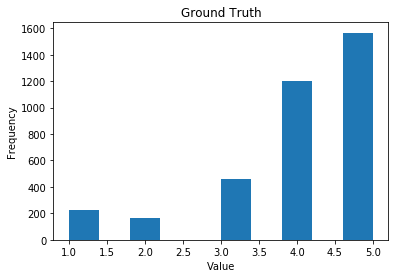

In [303]:
getHistogram('ratingScore', 'Ground Truth')

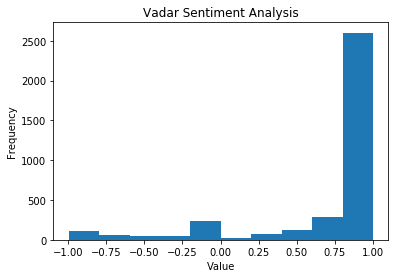

In [304]:

getHistogram('vader', 'Vadar Sentiment Analysis')

5AA) so both seem to skew highly to perfect or near perfect ratings/score, however in vader score, it drops off significantly after 1, whereas ratings have a slower descent (bit more spread).  This could indicate a discrepancy inbetween the way a person would rate a hotel out of 5 versus the language they would use in a review.  It is possible and likely that reviews for 4-5 stars have very similar vader sentiment score.

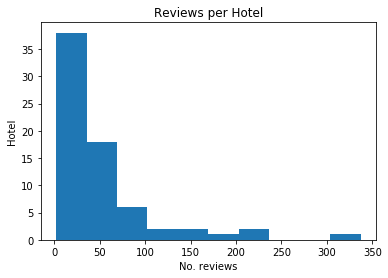

In [307]:

plt.hist(finaldf['hotelName'].value_counts())
plt.title("Reviews per Hotel")
plt.xlabel("No. reviews")
plt.ylabel("Hotel")
fig = plt.gcf()

5AB) Yes, so most hotels have less than 50 reviews (and in fact probably have less than 10), and only a few hotels have hundreds of reviews.  This makes sense, it is conceivable that some brand name large hotels with tons of patrons get lots of reviews (or incentivize guests to leave reviews), but that would only be a handful of hotels.  The more average or smaller hotels would likely get less reviews because of less patronage, and also people dont tend to review unless they are incentivized to or they had a very strong emotional response to their stay 

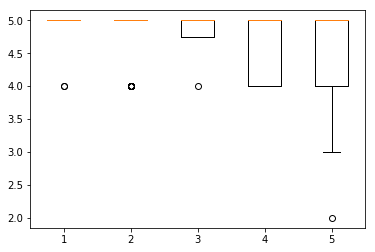

In [329]:
#Plot top 5 side-by-side boxplot for top 5 ground truth rated hotel
tp5gthotel = hotelRatingDfGtBEST.sort_values('avg_ratingScore',ascending=0).head(5)
tp5gthotel['hotelName'].values

hampton1 = finaldf.loc[finaldf['hotelName'] == tp5gthotel['hotelName'].values[0]]['ratingScore']
towneplace1 = finaldf.loc[finaldf['hotelName'] == tp5gthotel['hotelName'].values[1]]['ratingScore']
hiltonGarden1 = finaldf.loc[finaldf['hotelName'] == tp5gthotel['hotelName'].values[2]]['ratingScore']
homewood1 = finaldf.loc[finaldf['hotelName'] == tp5gthotel['hotelName'].values[3]]['ratingScore']
courtyard1 = finaldf.loc[finaldf['hotelName'] == tp5gthotel['hotelName'].values[4]]['ratingScore']

data = [hampton1, towneplace1, hiltonGarden1, homewood1, courtyard1]
# multiple box plots on one figure
plt.figure()
plt.boxplot(data)
plt.show()

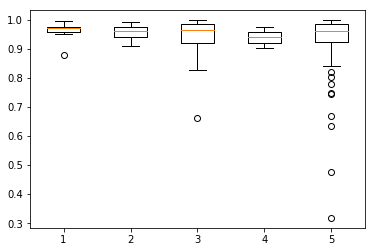

In [311]:
#Plot top 5 side-by-side boxplot for top 5 ground truth rated hotel
tp5gthotel = hotelRatingDfVdBEST.sort_values('avg_vader',ascending=0).head(5)
tp5gthotel['hotelName'].values

hampton = finaldf.loc[finaldf['hotelName'] == tp5gthotel['hotelName'].values[0]]['vader']
towneplace = finaldf.loc[finaldf['hotelName'] == tp5gthotel['hotelName'].values[1]]['vader']
hiltonGarden = finaldf.loc[finaldf['hotelName'] == tp5gthotel['hotelName'].values[2]]['vader']
homewood = finaldf.loc[finaldf['hotelName'] == tp5gthotel['hotelName'].values[3]]['vader']
courtyard = finaldf.loc[finaldf['hotelName'] == tp5gthotel['hotelName'].values[4]]['vader']

data = [hampton, towneplace, hiltonGarden, homewood, courtyard]
# multiple box plots on one figure
plt.figure()
plt.boxplot(data)
plt.show()

In [320]:
hampton.mean()

0.9627384615384617

In [319]:
hampton.var()

0.0007773325641025646

In [321]:
towneplace.mean()

0.9564999999999999

In [322]:
towneplace.var()

0.0012840733333333324

In [323]:
hiltonGarden.mean()

0.9422526315789473

In [324]:
hiltonGarden.var()

0.004038734452347084

In [325]:
homewood.mean()

0.9394

In [326]:
homewood.var()

0.0027676800000000015

In [327]:
courtyard.mean()

0.9268233333333336

In [328]:
courtyard.var()

0.011625932820224718

In [330]:
print(hampton1.mean())
print(hampton1.var())
print(towneplace1.mean())
print(towneplace1.var()) 
print(hiltonGarden1.mean()) 
print(hiltonGarden1.var())
print(homewood1.mean())
print(homewood1.var()) 
print(courtyard1.mean())
print(courtyard1.var())

4.909090909090909
0.08658008658008656
4.763636363636364
0.18383838383838377
4.75
0.25
4.7105263157894735
0.21123755334281646
4.655963302752293
0.33731450555954845


5BC)personally i find the box plots more informative because they provide a visual tool and make interpreting the data intuitive and easier, and confidence interval is a lot more tangible than variance for me personally

Text(0.5, 0, 'Vader Score')

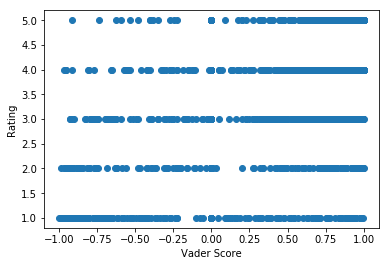

In [331]:
y = finaldf['ratingScore'].values
x = finaldf['vader'].values
plt.plot(x, y,"o")
plt.ylabel('Rating')
plt.xlabel('Vader Score')

In [80]:
#plz plz plz plz dont penalize me, i was writing my text answers 
#and accidentally ran this and i dont want to run all of my code again
#I am tired, and world-weary, I promise it works and is real
#sincerely, a student living on the edge
from scipy.stats.kde import gaussian_kde

k = gaussian_kde(np.vstack([x, y]))
xi, yi = np.mgrid[x.min():x.max():x.size**0.5*1j,y.min():y.max():y.size**0.5*1j]
zi = k(np.vstack([xi.flatten(), yi.flatten()]))

NameError: name 'x' is not defined

Text(0, 0.5, 'Rating')

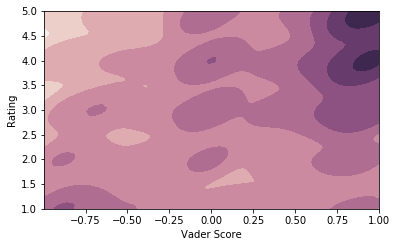

In [335]:
cmap = sns.cubehelix_palette(light=1, as_cmap=True)
fig = plt.figure(figsize=(6,8))
#ax1 = fig.add_subplot(211)
ax2 = fig.add_subplot(212)

#ax1.pcolormesh(xi, yi, np.log10(zi.reshape(xi.shape)), cmap=cmap)
ax2.contourf(xi, yi, np.log10(zi.reshape(xi.shape)), cmap=cmap)

#ax1.set_xlim(x.min(), x.max())
#ax1.set_ylim(y.min(), y.max())
ax2.set_xlim(x.min(), x.max())
ax2.set_ylim(y.min(), y.max())

#ax1.set_xlabel('Vader Score')
#ax1.set_ylabel('Rating')

ax2.set_xlabel('Vader Score')
ax2.set_ylabel('Rating')

5CA) So generally five star ratings and vader scores of 1 tend to line up, but overall, like any rating can elicit any vader score and pretty significantly.  So, as I've said previously throughout the assignment, there is a mismatch b/w what people will rate a hotel and what they will write in a review.  This could be so many things. It could be a mismatched mental model between experience and star rating (bad scale: 1-5 maybe), it could be one word reviews (like fake reviews), it could be sarcasm.  There are lots of things we are getting 'wrong'.

Text(0.5, 0, 'Rating')

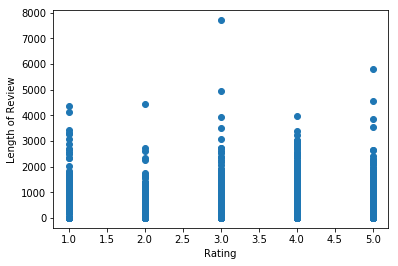

In [29]:
y1 = finaldf['reviewCol'].astype('str').str.len()
x1 = finaldf['ratingScore'].values
plt.plot(x1, y1,"o")
plt.ylabel('Length of Review')
plt.xlabel('Rating')

In [30]:
from scipy.stats.kde import gaussian_kde

k = gaussian_kde(np.vstack([x1, y1]))
xi, yi = np.mgrid[x1.min():x1.max():x1.size**0.5*1j,y1.min():y1.max():y1.size**0.5*1j]
zi = k(np.vstack([xi.flatten(), yi.flatten()]))

Text(0, 0.5, 'Rating')

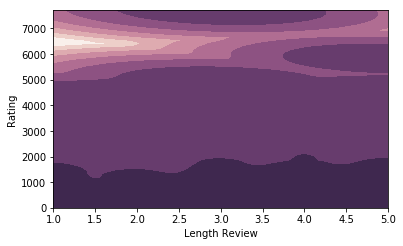

In [31]:
cmap = sns.cubehelix_palette(light=1, as_cmap=True)
fig = plt.figure(figsize=(6,8))
#ax1 = fig.add_subplot(211)
ax2 = fig.add_subplot(212)

#ax1.pcolormesh(xi, yi, np.log10(zi.reshape(xi.shape)), cmap=cmap)
ax2.contourf(xi, yi, np.log10(zi.reshape(xi.shape)), cmap=cmap)

#ax1.set_xlim(x.min(), x.max())
#ax1.set_ylim(y.min(), y.max())
ax2.set_xlim(x.min(), x.max())
ax2.set_ylim(y.min(), y.max())

#ax1.set_xlabel('Vader Score')
#ax1.set_ylabel('Rating')

ax2.set_xlabel('Length Review')
ax2.set_ylabel('Rating')

Text(0.5, 0, 'Vader Score')

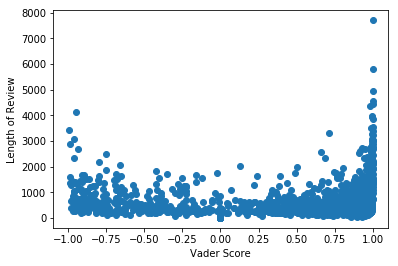

In [32]:
y2 = finaldf['reviewCol'].astype('str').str.len()
x2 = finaldf['vader'].values
plt.plot(x2, y2,"o")
plt.ylabel('Length of Review')
plt.xlabel('Vader Score')

In [26]:
from scipy.stats.kde import gaussian_kde

k = gaussian_kde(np.vstack([x2, y2]))
xi, yi = np.mgrid[x2.min():x2.max():x2.size**0.5*1j,y2.min():y2.max():y2.size**0.5*1j]
zi = k(np.vstack([xi.flatten(), yi.flatten()]))

Text(0, 0.5, 'Vader')

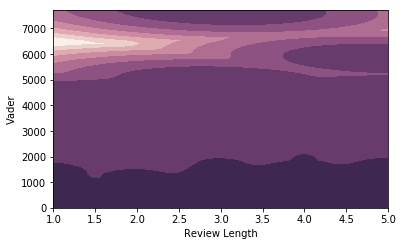

In [33]:
cmap = sns.cubehelix_palette(light=1, as_cmap=True)
fig = plt.figure(figsize=(6,8))
#ax1 = fig.add_subplot(211)
ax2 = fig.add_subplot(212)

#ax1.pcolormesh(xi, yi, np.log10(zi.reshape(xi.shape)), cmap=cmap)
ax2.contourf(xi, yi, np.log10(zi.reshape(xi.shape)), cmap=cmap)

#ax1.set_xlim(x.min(), x.max())
#ax1.set_ylim(y.min(), y.max())
ax2.set_xlim(x.min(), x.max())
ax2.set_ylim(y.min(), y.max())

#ax1.set_xlabel('Vader Score')
#ax1.set_ylabel('Rating')

ax2.set_xlabel('Review Length')
ax2.set_ylabel('Vader')

5CB) most reviews are under 2000 characters regardless of the vader score or rating, beyond that I can't see enough granularity to tell

Text(0.5, 0, 'Rating')

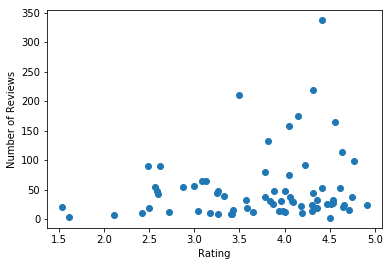

In [73]:
y3 = finaldf['hotelName'].value_counts()
x3 = finaldf.groupby('hotelName').mean()['ratingScore'].reset_index()['ratingScore']
plt.plot(x3, y3,"o")
plt.ylabel('Number of Reviews')
plt.xlabel('Rating')

Text(0.5, 0, 'Vader Score')

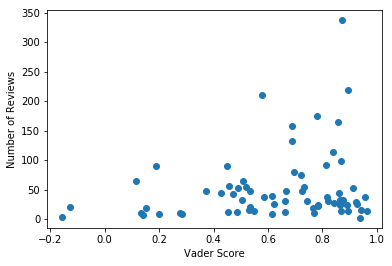

In [70]:
y4 = finaldf['hotelName'].value_counts()
x4 = finaldf.groupby('hotelName').mean()['vader'].reset_index()['vader']
plt.plot(x4, y4,"o")
plt.ylabel('Number of Reviews')
plt.xlabel('Vader Score'

5CC) hotels with lower ratings and vader scores tend to have less reviews.   